Load of a real dataset
-------------------------------------

About car crash injuries

### Description of the variables

<img src="Doc/ListeFichiers.png">

...

<img src="Doc/OrganisationBD.png">


### Notebook objectives

We want to know how good we can predict the severity of the accident, based on characteristics about the driver.

Then we will quantify the importance of every driver related features in this prediction.

-----

In [42]:
import os
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, svm
from sklearn.feature_selection import SelectPercentile, f_classif
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [23, 10]
from statsmodels.graphics.mosaicplot import mosaic

In [43]:
cwd = os.getcwd()
dir_path  = os.path.join(cwd, 'GES2012')
input_file_path = os.path.join(dir_path, 'PERSON.TXT')
input_data = pd.read_csv(input_file_path, delimiter='\t')
print('shape:{}'.format(input_data.shape))

shape:(153077, 58)


In [25]:
input_data.head()

,CASENUM,VEH_NO,PER_NO,SEX_IM,INJSEV_IM,EJECT_IM,PERALCH_IM,SEAT_IM,AGE_IM,VE_FORMS,...,DRUGTST2,DRUGTST3,DRUGRES1,DRUGRES2,DRUGRES3,HOSPITAL,P_SF1,P_SF2,P_SF3,LOCATION
0,201210432623,1,1,1,0,0,0,11,43,2,...,0,0,95,0,0,0,0,0,0,0
1,201210432623,2,1,2,0,0,0,11,68,2,...,0,0,95,0,0,0,0,0,0,0
2,201210432628,1,1,1,1,0,0,11,67,2,...,0,0,95,0,0,5,0,0,0,0
3,201210432628,1,2,2,1,0,0,13,69,2,...,0,0,0,0,0,5,0,0,0,0
4,201210432628,2,1,2,0,0,0,11,36,2,...,0,0,95,0,0,0,0,0,0,0


Add some info by merging with other files
----------------------------------------------


In [27]:
# select drivers
drivers = input_data[input_data['PER_TYP'] == 1]

# select car and motorcycle passengers
passengers = input_data[input_data['PER_TYP'] == 2]
passengers = passengers[['CASENUM', 'VEH_NO', 'PER_NO', 'INJ_SEV']]

In [28]:
# only keep passenger id and join with driver by vehicule num and casenum
new_data = pd.merge (drivers, passengers, on=['CASENUM', 'VEH_NO' ], how='inner', left_index=True, copy=False)

In [29]:
input_data = new_data

# Some df manipulations

In [30]:
input_data.head()

,CASENUM,VEH_NO,PER_NO_x,SEX_IM,INJSEV_IM,EJECT_IM,PERALCH_IM,SEAT_IM,AGE_IM,VE_FORMS,...,DRUGRES1,DRUGRES2,DRUGRES3,HOSPITAL,P_SF1,P_SF2,P_SF3,LOCATION,PER_NO_y,INJ_SEV_y
3,201210432628,1,1,1,1,0,0,11,67,2,...,95,0,0,5,0,0,0,0,2,1
6,201210432637,1,1,1,0,0,1,11,48,1,...,95,0,0,0,0,0,0,0,2,0
8,201210432654,1,1,2,0,0,0,11,32,3,...,95,0,0,0,0,0,0,0,2,0
13,201210432657,1,1,2,0,0,0,11,17,2,...,95,0,0,0,0,0,0,0,2,0
17,201210432662,1,1,1,0,0,0,11,23,2,...,95,0,0,0,0,0,0,0,2,1


In [15]:
input_data.describe()

,CASENUM,VEH_NO,PER_NO_x,SEX_IM,EJECT_IM,PERALCH_IM,SEAT_IM,AGE_IM,VE_FORMS,WEIGHT,...,DRUGRES1,DRUGRES2,DRUGRES3,HOSPITAL,P_SF1,P_SF2,P_SF3,LOCATION,PER_NO_y,INJ_SEV
count,3.997600e+04,39976.000000,39976.000000,39976.000000,39976.000000,39976.000000,39976.0,39976.000000,39976.000000,39976.000000,...,39976.000000,39976.0,39976.0,39976.000000,39976.000000,39976.000000,39976.000000,39976.0,39976.000000,39976.000000
mean,2.012364e+11,1.573044,1.002476,1.457149,0.061187,0.038148,11.0,36.827522,2.058685,89.159264,...,48.173004,0.0,0.0,1.109316,0.376151,0.225360,0.225360,0.0,2.552306,0.852587
std,2.792924e+07,0.719090,0.101367,0.498167,0.669544,0.191556,0.0,15.759512,0.848238,85.272849,...,118.660303,0.0,0.0,2.149999,5.924868,4.718096,4.718096,0.0,1.094584,1.738058
min,2.012104e+11,1.000000,1.000000,1.000000,0.000000,0.000000,11.0,4.000000,1.000000,1.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
25%,2.012177e+11,1.000000,1.000000,1.000000,0.000000,0.000000,11.0,24.000000,2.000000,13.152102,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.000000
50%,2.012281e+11,1.000000,1.000000,1.000000,0.000000,0.000000,11.0,34.000000,2.000000,55.317700,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.000000
75%,2.012297e+11,2.000000,1.000000,2.000000,0.000000,0.000000,11.0,47.000000,2.000000,116.900100,...,95.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,3.000000,1.000000
max,2.012995e+11,20.000000,7.000000,2.000000,8.000000,1.000000,11.0,112.000000,20.000000,1629.406412,...,999.000000,0.0,0.0,9.000000,99.000000,99.000000,99.000000,0.0,28.000000,9.000000


In [16]:
input_data.index

Int64Index([     3,      6,      8,     13,     17,     27,     30,     34,
                41,     43,
            ...
            153040, 153041, 153043, 153044, 153061, 153063, 153064, 153066,
            153068, 153069],
           dtype='int64', length=39976)

In [31]:
# Dataset cleaning & outliers removal

input_data = input_data[input_data['INJ_SEV_y'] < 6]

for column in input_data.columns:
    n_nans = input_data[column].isnull().sum()
    if n_nans > 0:
        print(column, n_nans)

Dataset creation
------------------

We create the following:

- input: every variables about the driver
- output: deadly accident or not

For that we need to:

- keep all the other columns as the input vector corresponding to a driver
- keep separated the INJ_SEV column as the target (target = output to be predicted)
- discard the column INJSEV_IM which codes the same as INJ_SEV (learning leakage otherwise)

In [34]:
data = input_data[~input_data.MAKE.isnull()]
target = data.pop('INJ_SEV_y')
casenum = data.pop('CASENUM')

print(data.shape)
print(target.shape)

(38795, 58)
(38795,)


In [35]:
target = (target > 0).astype('float')

Learning of classification models
----------------------------------------
Driver Features (X) -> Death / No Death (y)  

In [49]:
# Train on half of the data while reserving the other half for model comparisons
X_train, X_test, y_train, y_test = train_test_split(data.values, target.values, test_size=.5, stratify=target.values)

In [59]:
nb_exe_train = X_train.shape[0]
clf = KNeighborsClassifier(int(np.sqrt(nb_exe_train)))

clf.fit(X_train, y_train)
clf_preds = clf.predict(X_test)
clf_performance2 = accuracy_score(y_test, clf_preds)
clf_performance3 = average_precision_score(y_test, clf_preds, average='weighted')
print('KNN: Accuracy = {}'.format(clf_performance2))
print('KNN: Average Precision = {}'.format(clf_performance3))
clf_performance4 = confusion_matrix(y_test, clf_preds)
print('KNN: Matrix Confusion')
print(clf_performance4)

KNN: Accuracy = 0.7125992370347458
KNN: Average Precision = 0.42603329199708284
KNN: Matrix Confusion
[[11755  1232]
 [ 4343  2068]]


In [50]:
print('Number of dead drivers in the train set: {}'.format(y_train[y_train == 1].shape[0]))
print('Number of not dead drivers in the train set: {}'.format(y_train[y_train == 0].shape[0]))
print('Number of dead drivers in the test set: {}'.format(y_test[y_test == 1].shape[0]))
print('Number of not dead drivers in the test set: {}'.format(y_test[y_test == 0].shape[0]))

Number of dead drivers in the train set: 6411
Number of not dead drivers in the train set: 12986
Number of dead drivers in the test set: 6411
Number of not dead drivers in the test set: 12987


In [56]:
clf = KNeighborsClassifier(5)

clf.fit(X_train, y_train)
clf_preds = clf.predict(X_test)
clf_performance2 = accuracy_score(y_test, clf_preds)
clf_performance3 = average_precision_score(y_test, clf_preds, average='weighted')
print('KNN: Accuracy = {}'.format(clf_performance2))
print('KNN: Average Precision = {}'.format(clf_performance3))
clf_performance4 = confusion_matrix(y_test, clf_preds)
print('KNN: Matrix Confusion')
print(clf_performance4)

KNN: Accuracy = 0.7312609547376018
KNN: Average Precision = 0.4709814734800959
KNN: Matrix Confusion
[[11057  1930]
 [ 3283  3128]]


In [60]:
clf = svm.SVC(kernel='linear', class_weight='balanced')         
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

SVM: Area under the ROC curve = 0.7420037293691949
SVM: Accuracy = 0.7761624909784514
SVM: Average Precision = 0.5470012801105442


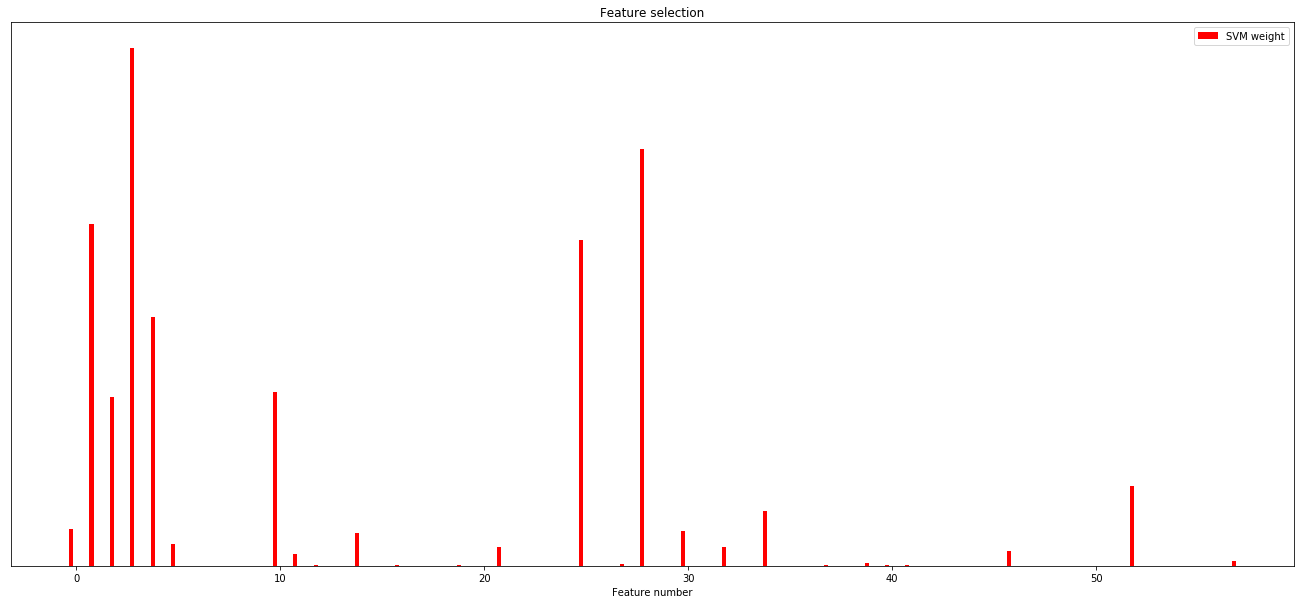

[7.03614147e-02 6.60158183e-01 3.26407795e-01 1.00000000e+00
 4.80178564e-01 4.15075165e-02 1.37936967e-21 4.62913171e-04
 3.61699190e-04 1.51728743e-04 3.35943181e-01 2.35100693e-02
 7.91104118e-04 9.22088682e-07 6.32484678e-02 0.00000000e+00
 1.12957350e-03 2.64172278e-05 1.47043246e-05 1.09194943e-03
 1.88846418e-04 3.71299363e-02 4.07387743e-05 5.20754363e-04
 8.99616788e-08 6.29700700e-01 1.83693144e-06 4.15397693e-03
 8.05810708e-01 3.71578697e-05 6.63403257e-02 2.99835327e-08
 3.61580274e-02 2.47259317e-23 1.04885806e-01 1.37936967e-21
 1.88036068e-06 1.30573118e-03 1.15798684e-05 5.12990398e-03
 6.07845471e-04 1.87354480e-03 4.63579923e-05 2.46686216e-04
 3.84524800e-04 1.07609321e-04 2.77043013e-02 0.00000000e+00
 0.00000000e+00 7.83407525e-06 0.00000000e+00 0.00000000e+00
 1.53776528e-01 2.98609037e-05 1.39933740e-07 1.39933740e-07
 0.00000000e+00 8.69223199e-03]


In [64]:
clf_preds = clf.predict(X_test)
clf_performance1 = roc_auc_score(y_test, clf_preds)
clf_performance2 = accuracy_score(y_test, clf_preds)
clf_performance3 = average_precision_score(y_test, clf_preds, average='weighted')
print('SVM: Area under the ROC curve = {}'.format(clf_performance1))
print('SVM: Accuracy = {}'.format(clf_performance2))
print('SVM: Average Precision = {}'.format(clf_performance3))

plt.figure(1)
plt.clf()

X_indices = np.arange(X_train.shape[-1])
svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight', color='r')
plt.title("Feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

print(svm_weights)

In [66]:
svm_weights.argsort()

array([47, 56, 48, 50, 15, 51, 33,  6, 35, 31, 24, 55, 54, 13, 26, 36, 49,
       38, 18, 17, 53, 29, 22, 42, 45,  9, 20, 43,  8, 44,  7, 23, 40, 12,
       19, 16, 37, 41, 27, 39, 57, 11, 46, 32, 21,  5, 14, 30,  0, 34, 52,
        2, 10,  4, 25,  1, 28,  3])